# Unbinned likelihood fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Define fit model

In [2]:
tmax = 100

# Exponential decay + uniform background

def myfun(x,par):

    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = fdec/tdec * np.exp(-x/tdec)

    # Add constant term
    
    val += (1-fdec)* 1./tmax

    return val

# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,2))

    # decay time
    
    tdec = par[0]
    
    # Decay fraction
    
    fdec = par[1]

    # Exponential probability distribution
    
    val = 1/tdec * np.exp(-x/tdec)

    der[:,0] = val*(x-tdec)/tdec/tdec
    
    # Take background fraction into account
    
    der[:0] *= fdec
    
    der[:,1] = val - 1./tmax
    
    val = fdec*val + (1-fdec)* 1./tmax

    return val,der


### (2) Read input data

In [3]:
# Read background fit output

# Nevt = 100
# infile = "http://hep.fuw.edu.pl/u/zarnecki/saed23/11_example_data_"+str(Nevt)+".dat"

# Old data (as shown in lecture slides)

Nevt = 100
infile = "http://hep.fuw.edu.pl/u/zarnecki/saed22/10_example_data_"+str(Nevt)+".dat"


xvec = np.loadtxt(infile)

### (3) Iterative fit

In [4]:
# Number of function parameters to consider  (fixed for this model)

Nfun = 2

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 2.
parini[1] = 0.99

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

loglini = np.sum(np.log(fini))

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  LL =  %8.3f   LL/N = %8.5f " % (loglini,loglini/xvec.size))


Iterative fit procedure starting from parameter values
  [2.   0.99]
  LL =  -323.821   LL/N = -3.23821 


In [5]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.001   # Required precision (distance from minimum)

loglmin = loglini
parmin = parini

par = parini

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]/fval)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/fval/fval)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
#        C[l,l] *= 1 + lam
        C[l,l] += lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    loglnew = np.sum(np.log(fnew))

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  LL =  %8.3f   LL = %8.5f " % (loglnew,loglnew/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if loglnew > loglmin :
        lam /= 10
        loglmin = loglnew
        par = parnew
    else:
        lam *= 10



Iteration step  1  with lambda =  0.01
  [2.20652822 0.98035806]
  LL =  -310.964   LL = -3.17310 
  distance to minimum:  18.256760017154143

Iteration step  2  with lambda =  0.001
  [2.27697261 0.96200322]
  LL =  -299.852   LL = -3.05971 
  distance to minimum:  16.055809095213057

Iteration step  3  with lambda =  0.0001
  [2.25641675 0.92926082]
  LL =  -290.576   LL = -2.96506 
  distance to minimum:  13.733304978656628

Iteration step  4  with lambda =  1e-05
  [2.2097543  0.87854167]
  LL =  -284.214   LL = -2.90014 
  distance to minimum:  9.781356684965749

Iteration step  5  with lambda =  1.0000000000000002e-06
  [2.16209    0.82068906]
  LL =  -281.461   LL = -2.87206 
  distance to minimum:  4.5619373663437885

Iteration step  6  with lambda =  1.0000000000000002e-07
  [2.13223718 0.78624113]
  LL =  -281.023   LL = -2.86758 
  distance to minimum:  0.8202896476635467

Iteration step  7  with lambda =  1.0000000000000002e-08
  [2.12371085 0.78020073]
  LL =  -281.013   

In [6]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

logl = np.sum(np.log(fvec))

print("\n LL =  %8.3f   LL/Ndf = %8.5f " % (logl,logl/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     2.122  +/-  0.218 
     0.780  +/-  0.045 

 Correlation matrix

[1.    0.148]
[0.148 1.   ]

 LL =  -281.013   LL/Ndf = -2.86748 


### (4) Draw data and fit

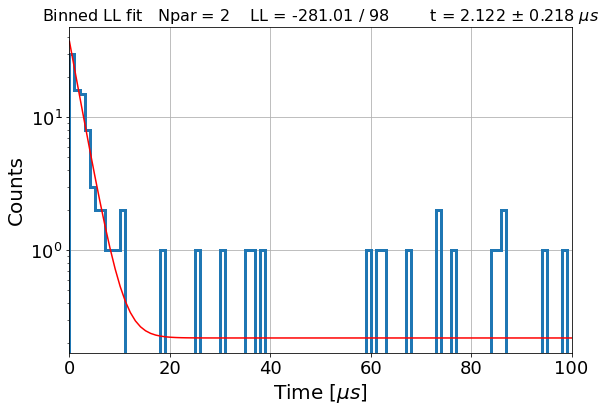

In [7]:
# Histogram for display

tmax = 100.
Nbin = 100

# Fitted dependence wraper

def myfit(fx, fpar):
    
    tdec = fpar[0]
    fdec = fpar[1]

    # Exponential probability distribution
    
    fval = fdec/tdec * np.exp(-fx/tdec)

    # Add constant term
    
    fval += (1-fdec)/tmax
    
    # Normalization
    
    return Nevt*tmax/Nbin*fval


Nf = 100
xfun = np.linspace(0.,tmax,Nf)
yfun = myfit(xfun,par)

plt.figure(figsize=(9, 6))

plt.hist(xvec,range=[0,tmax],bins=Nbin,log=True, histtype='step',linewidth=3)
plt.plot(xfun,yfun,'r-')
plt.xlim([0,tmax])

plt.title('Binned LL fit   Npar = {}    LL = {:.2f} / {}        t = {:.3f} $\pm$ {:.3f} $\mu s$'.format(Nfun,logl,xvec.size-Nfun,par[0],epar[0]),size=16)
plt.ylabel('Counts',size=20)
plt.xlabel('Time [$\mu s$]',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')


fname = '11_unbinned_fit_'+str(Nevt)+'_'+str(Nbin)+'.png'
plt.savefig(fname)